In [1]:
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
import ardent
# from scipy.ndimage import zoom
import time
import pandas as pd

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
# from proglearn.sims import generate_gaussian_parity

import pandas as pd

In [2]:
context = sns.plotting_context(context="talk", font_scale=1)
sns.set_context(context)

In [3]:
from sklearn.datasets import make_blobs


def _generate_2d_rotation(theta=0):
    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    return R


def generate_gaussian_parity(
    n_samples,
    centers=None,
    class_label=None,
    cluster_std=0.25,
    angle_params=None,
    random_state=None,
):

    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])

    if class_label == None:
        class_label = [0, 1, 1, 0]

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X, y = make_blobs(
        n_samples=samples_per_blob,
        n_features=2,
        centers=centers,
        cluster_std=cluster_std,
    )

    for blob in range(blob_num):
        y[np.where(y == blob)] = class_label[blob]

    if angle_params != None:
        R = _generate_2d_rotation(angle_params)
        X = X @ R

    return X, y

In [4]:
# def to_grid(X_task):
#     h = 0.01
#     x_min, x_max = X_task[:,0].min()-0.1, X_task[:,0].max()+0.1
#     y_min, y_max = X_task[:,1].min()-0.1, X_task[:,1].max()+0.1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#     new_X_task = np.c_[xx.ravel(), yy.ravel()]
#     return xx, yy, new_X_task

In [4]:
def init_forest(max_depth):
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    # uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
    #                                         default_transformer_kwargs = default_transformer_kwargs,
    #                                         default_voter_class = default_voter_class,
    #                                         default_voter_kwargs = default_voter_kwargs,
    #                                         default_decider_class = default_decider_class,
    #                                         default_decider_kwargs = default_decider_kwargs)
    return progressive_learner

In [5]:
def grid_to_score(l2f_task, test_task, xx, yy):
    pred = np.empty((len(test_task), ))
    l2f_task = l2f_task.reshape(xx.shape)
    for i in range(len(test_task)):
        x_ind = np.where(test_task[i,0] <= xx[0,:])[0][0]
        y_ind = np.where(test_task[i,1] <= yy[:,0])[0][0]
        pred[i] = l2f_task[x_ind, y_ind]
    # pred = pred.reshape((1,-1))

    return pred

In [6]:
def grid_to_pred(task_pos_reshaped, test_task, xx, yy):
    pred = np.empty((len(test_task), ))

    for i in range(len(test_task)):
        x_ind = np.where(test_task[i,0] <= xx[0,:])[0][0]
        y_ind = np.where(test_task[i,1] <= yy[:,0])[0][0]
        pred[i] = task_pos_reshaped[y_ind, x_ind]

    pred = pred.reshape((-1,1))
    pred = np.hstack((pred, 1-pred))
    pred = np.argmax(pred, axis=1)
    
    return pred

In [7]:
def default_lddmm(in_task_pos_reshaped, cross_task_pos_reshaped):
    print("start running lddmm")
    transform = ardent.Transform()
    reference = in_task_pos_reshaped
    moving = cross_task_pos_reshaped
    transform.register(target=moving, template=reference, num_iterations=50)
    deformed_moving = transform.transform_image(
        subject=moving,
        output_shape=moving.shape,
        deform_to='template')
    print("finish running lddmm")
    return deformed_moving, transform

In [98]:
try:
    1+"str"
except ValueError:
    print("?")
except:
    print("e")

e


In [102]:
def lddmm_reg_old(in_task_pos_reshaped, cross_task_pos_reshaped, affines, n_ite, calibrate):
    print("start running lddmm")
    transform = ardent.Transform()
    reference = in_task_pos_reshaped
    moving = cross_task_pos_reshaped
    # n_ite = 50
    try:
        transform.register(target=moving, template=reference, num_iterations=n_ite, initial_affine=affines)
    except RuntimeError:
        print("finer")
        try:
            transform.register(target=moving, template=reference, affine_stepsize=0.2, num_iterations=n_ite, initial_affine=affines)
        except RuntimeError:
            try:
                transform.register(target=moving, template=reference, affine_stepsize=0.1, num_iterations=n_ite, initial_affine=affines)
            except RuntimeError:
                return moving, None
    except:
        return moving, None

    deformed_moving = transform.transform_image(
        subject=moving,
        output_shape=moving.shape,
        deform_to='template')

    print("finish running lddmm")
    return deformed_moving, transform

In [123]:
def lddmm_reg(in_task_pos_reshaped, cross_task_pos_reshaped, affines, n_ite, calibrate):
    print("start running lddmm")
    transform = ardent.Transform()
    reference = in_task_pos_reshaped
    moving = cross_task_pos_reshaped
    # n_ite = 50
    try:
        transform.register(target=moving, template=reference, num_iterations=n_ite, initial_affine=affines)
    except RuntimeError:
        print("finer")
        try:
            transform.register(target=moving, template=reference, affine_stepsize=0.2, num_iterations=n_ite, initial_affine=affines)
        # except RuntimeError:
        #     try:
        #         transform.register(target=moving, template=reference, affine_stepsize=0.1, num_iterations=n_ite, initial_affine=affines)
        #     except RuntimeError:
        #         return moving, reference, None
        except:
            return moving, reference, None
    except:
        return moving, reference, None

    deformed_moving = transform.transform_image(
        subject=moving,
        output_shape=moving.shape,
        deform_to='template')

    deformed_reference = transform.transform_image(
        subject=reference,
        output_shape=reference.shape,
        deform_to='target'
    )
    print("finish running lddmm")
    return deformed_moving, deformed_reference, transform

In [10]:
n_task1=300; n_task2=300; n_test=1000; task1_angle=0; task2_angle=np.pi/4; n_trees=10

#source data
X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)
#target data
X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

In [11]:
errors = np.zeros(6, dtype=float)

### pure forests (single-task UF)

In [61]:
xx1, yy1, test_task1_grid = to_grid(test_task1)
xx2, yy2, test_task2_grid = to_grid(test_task2)

# train on task1 & predict on both

progressive_learner = init_forest(max_depth=ceil(log2(n_task1)))
progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)

train1pred1 = progressive_learner.predict(test_task1_grid, task_id=0, registration=True)
train1pred2 = progressive_learner.predict(test_task2_grid, task_id=0, registration=True)

train1pred1_reshaped = train1pred1[0][:,0].reshape(xx1.shape)
train1pred2_reshaped = train1pred2[0][:,0].reshape(xx2.shape)

errors[0] = 1 - np.mean(
    grid_to_pred(train1pred1_reshaped, test_task1, xx1, yy1) == test_label_task1
)  # l2f task1 error
errors[1] = 1 - np.mean(
    grid_to_pred(train1pred2_reshaped, test_task2, xx2, yy2) == test_label_task2
)  # l2f task2 error

# train on task2 & predict on both

progressive_learner = init_forest(max_depth=ceil(log2(n_task2)))
progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

train2pred1 = progressive_learner.predict(test_task1_grid, task_id=0, registration=True)
train2pred2 = progressive_learner.predict(test_task2_grid, task_id=0, registration=True)

train2pred1_reshaped = train2pred1[0][:,0].reshape(xx1.shape)
train2pred2_reshaped = train2pred2[0][:,0].reshape(xx2.shape)

errors[2] = 1 - np.mean(
    grid_to_pred(train2pred1_reshaped, test_task1, xx1, yy1) == test_label_task1
)  # l2f task1 error
errors[3] = 1 - np.mean(
    grid_to_pred(train2pred2_reshaped, test_task2, xx2, yy2) == test_label_task2
)  # l2f task2 error

In [303]:
# lddmm
train1pred2_deformed, model1 = lddmm_reg(train2pred2_reshaped, train1pred2_reshaped, affine1.T)
errors[4] = 1 - np.mean(
    grid_to_pred(train1pred2_deformed, test_task2, xx2, yy2) == test_label_task2
)  # l2f o lddmm task2 mapped onto task1 error

train2pred1_deformed, model2 = lddmm_reg(train1pred1_reshaped, train2pred1_reshaped, affine2.T)
errors[5] = 1 - np.mean(
    grid_to_pred(train2pred1_deformed, test_task1, xx1, yy1) == test_label_task1
)  # l2f o lddmm task1 mapped onto task2 error

start running lddmm
finish running lddmm
start running lddmm
finish running lddmm


In [276]:
def exp(n_task1, n_task2, n_test=1000, task1_angle=0, task2_angle=np.pi/4, n_trees=10, rand=None):

    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

    xx1, yy1, test_task1_grid = to_grid(test_task1)
    xx2, yy2, test_task2_grid = to_grid(test_task2)

    errors = np.zeros(6, dtype=float)

    # train on task1 & predict on both

    progressive_learner = init_forest(max_depth=ceil(log2(n_task1)))
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)

    train1pred1 = progressive_learner.predict(test_task1_grid, task_id=0, registration=True)
    train1pred2 = progressive_learner.predict(test_task2_grid, task_id=0, registration=True)

    train1pred1_reshaped = train1pred1[0][:,0].reshape(xx1.shape)
    train1pred2_reshaped = train1pred2[0][:,0].reshape(xx2.shape)

    errors[0] = 1 - np.mean(
        grid_to_pred(train1pred1_reshaped, test_task1, xx1, yy1) == test_label_task1
    )  # l2f task1 error
    errors[1] = 1 - np.mean(
        grid_to_pred(train1pred2_reshaped, test_task2, xx2, yy2) == test_label_task2
    )  # l2f task2 error

    # train on task2 & predict on both

    progressive_learner = init_forest(max_depth=ceil(log2(n_task2)))
    progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

    train2pred1 = progressive_learner.predict(test_task1_grid, task_id=0, registration=True)
    train2pred2 = progressive_learner.predict(test_task2_grid, task_id=0, registration=True)

    train2pred1_reshaped = train2pred1[0][:,0].reshape(xx1.shape)
    train2pred2_reshaped = train2pred2[0][:,0].reshape(xx2.shape)

    errors[2] = 1 - np.mean(
        grid_to_pred(train2pred1_reshaped, test_task1, xx1, yy1) == test_label_task1
    )  # l2f task1 error
    errors[3] = 1 - np.mean(
        grid_to_pred(train2pred2_reshaped, test_task2, xx2, yy2) == test_label_task2
    )  # l2f task2 error

    # # lddmm estimating affines
    # train1pred2_deformed, model1 = default_lddmm(train2pred2_reshaped, train1pred2_reshaped)
    # errors[4] = 1 - np.mean(
    #     grid_to_pred(train1pred2_deformed, test_task2, xx2, yy2) == test_label_task2
    # )  # l2f o lddmm task2 mapped onto task1 error

    # train2pred1_deformed, model2 = default_lddmm(train1pred1_reshaped, train2pred1_reshaped)
    # errors[5] = 1 - np.mean(
    #     grid_to_pred(train2pred1_deformed, test_task1, xx1, yy1) == test_label_task1
    # )  # l2f o lddmm task1 mapped onto task2 error

    # lddmm using estimated affines
    train1pred2_deformed, model1 = lddmm_reg(train2pred2_reshaped, train1pred2_reshaped, affine1.T)
    errors[4] = 1 - np.mean(
        grid_to_pred(train1pred2_deformed, test_task2, xx2, yy2) == test_label_task2
    )  # l2f o lddmm task2 mapped onto task1 error

    train2pred1_deformed, model2 = lddmm_reg(train1pred1_reshaped, train2pred1_reshaped, affine2.T)
    errors[5] = 1 - np.mean(
        grid_to_pred(train2pred1_deformed, test_task1, xx1, yy1) == test_label_task1
    )  # l2f o lddmm task1 mapped onto task2 error

    # return errors, model1.affine.T, model2.affine.T
    return errors

### train on both tasks

In [10]:
pickle_in = open("estimated_initial_affines-45deg-n_sample=500-n_trial=100-n_trees=20.pickle", "rb")
affines = pickle.load(pickle_in)

In [11]:
def init_UF(max_depth):
    # np.random.seed(1)
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                            default_transformer_kwargs = default_transformer_kwargs,
                            default_voter_class = default_voter_class,
                            default_voter_kwargs = default_voter_kwargs,
                            default_decider_class = default_decider_class,
                            default_decider_kwargs = default_decider_kwargs)
    return uf

In [12]:
def to_grid(test_task1, test_task2):
    h = 0.01
    x_min1, x_max1 = test_task1[:,0].min(), test_task1[:,0].max()
    y_min1, y_max1 = test_task1[:,1].min(), test_task1[:,1].max()
    x_min2, x_max2 = test_task2[:,0].min(), test_task2[:,0].max()
    y_min2, y_max2 = test_task2[:,1].min(), test_task2[:,1].max()

    x_min = min(x_min1, x_min2) - 0.1
    x_max = max(x_max1, x_max2) + 0.1
    y_min = min(y_min1, y_min2) - 0.1
    y_max = max(y_max1, y_max2) + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    new_test_task = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, new_test_task

In [45]:
n_task1=100; n_task2=100; n_test=1000; task1_angle=0; task2_angle=np.pi*(80/180); n_trees=10
# n_task1=n1; n_task2=n2; n_test=1000; task1_angle=0; task2_angle=np.pi/4; n_trees=10

#source data
X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)
#target data
X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

In [46]:
# L2F
max_depth = ceil(log2(100))
xx2, yy2, test_task2_grid = to_grid(test_task1, test_task2)
errors = np.zeros(6, dtype=float)

l2f = init_forest(max_depth)
l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
l2f.add_task(X_task2, y_task2, num_transformers=n_trees)

l2f_task1 = l2f.predict(test_task2_grid, task_id=0, registration=True)
l2f_task2 = l2f.predict(test_task2_grid, task_id=1, registration=True)

task1pred1_reshaped = l2f_task1[0][:,0].reshape(xx2.shape)
task1pred2_reshaped = l2f_task1[1][:,0].reshape(xx2.shape)
task2pred1_reshaped = l2f_task2[0][:,0].reshape(xx2.shape)
task2pred2_reshaped = l2f_task2[1][:,0].reshape(xx2.shape)

vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)
errors[1] = 1 - np.mean(
    grid_to_pred(vote1, test_task1, xx2, yy2) == test_label_task1
)  # l2f task1 error

vote2 = np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)
errors[3] = 1 - np.mean(
    grid_to_pred(vote2, test_task2, xx2, yy2) == test_label_task2
)  # l2f task2 error

In [51]:
# lddmm
task2pred2_deformed, model1 = lddmm_reg_old(task2pred2_reshaped, task1pred1_reshaped, affines[1].T, 50, False)
task1pred1_deformed, model2 = lddmm_reg_old(task1pred1_reshaped, task2pred2_reshaped, affines[2].T, 50, False)
# task2pred2_deformed, task1pred1_deformed, model1 = lddmm_reg(task2pred2_reshaped, task1pred1_reshaped, affines[1].T, 50, False)
# task1pred1_deformed, task2pred2_deformed, model1 = lddmm_reg(task1pred1_reshaped, task2pred2_reshaped, affines[2].T, 50, False)

# L2F o lddmm
vote1 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)
errors[4] = 1 - np.mean(
    grid_to_pred(vote1, test_task1, xx2, yy2) == test_label_task1
)  # l2f o lddmm task1 error
vote2 = np.mean([task2pred2_reshaped, task2pred2_deformed], axis=0)
errors[5] = 1 - np.mean(
    grid_to_pred(vote2, test_task2, xx2, yy2) == test_label_task2
)  # l2f o lddmm task2 error



start running lddmm
finish running lddmm
start running lddmm
finish running lddmm


In [154]:
transform = ardent.Transform()
reference = task1pred1_reshaped
moving = task2pred2_reshaped
transform.register(target=moving, template=reference, num_iterations=50, initial_affine=np.array([[0,1,0],[-1,0,0],[0,0,1]]))

deformed_moving = transform.transform_image(
    subject=moving,
    output_shape=moving.shape,
    deform_to='template')
deformed_reference = transform.transform_image(
    subject=reference,
    output_shape=reference.shape,
    deform_to='target'
)

In [58]:
# fig,axs = plt.subplots(1,6, figsize=(30,4))
# axs[0].imshow(task1pred1_reshaped)
# axs[3].imshow(task2pred2_reshaped)
# axs[4].imshow(task1pred1_deformed)
# axs[5].imshow(task2pred2_deformed)

In [59]:
# fig,axs = plt.subplots(1,6, figsize=(30,4))
# axs[0].imshow(task1pred1_reshaped)
# axs[1].imshow(task1pred2_reshaped)
# axs[2].imshow(task2pred1_reshaped)
# axs[3].imshow(task2pred2_reshaped)
# axs[4].imshow(task1pred1_deformed)
# axs[5].imshow(task2pred2_deformed)

In [69]:
experiment(100,100,max_depth=ceil(log2(100)))

start running lddmm
finish running lddmm


array([0.085, 0.052, 0.099, 0.112, 0.056, 0.077])

In [116]:
error = np.array(
    Parallel(n_jobs=-1,verbose=1)(
    delayed(experiment)(
        100,100,task2_angle=np.pi*(70/180),
        max_depth=ceil(log2(100))
    ) for _ in range(25)
    )
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.5min finished


In [80]:
def experiment_paper(n_task1, n_task2, n_test=1000, task1_angle=0, task2_angle=np.pi/2, n_trees=10, max_depth=None):

    errors = np.zeros(6,dtype=float)

    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    naive_uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    
    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

    uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)
    
    naive_uf_train_x = np.concatenate((X_task1,X_task2),axis=0)
    naive_uf_train_y = np.concatenate((y_task1,y_task2),axis=0)
    naive_uf.add_task(
            naive_uf_train_x, naive_uf_train_y, num_transformers=n_trees
            )
    
    uf_task1=uf.predict(test_task1, transformer_ids=[0], task_id=0)
    l2f_task1=progressive_learner.predict(test_task1, task_id=0)
    uf_task2=uf.predict(test_task2, transformer_ids=[1], task_id=1)
    l2f_task2=progressive_learner.predict(test_task2, task_id=1)
    naive_uf_task1 = naive_uf.predict(
        test_task1, transformer_ids=[0], task_id=0
    )
    naive_uf_task2 = naive_uf.predict(
        test_task2, transformer_ids=[0], task_id=0
    )

    errors[0] = 1 - np.mean(
        uf_task1 == test_label_task1
    )
    errors[1] = 1 - np.mean(
        l2f_task1 == test_label_task1
    )
    errors[2] = 1 - np.mean(
        uf_task2 == test_label_task2
    )
    errors[3] = 1 - np.mean(
        l2f_task2 == test_label_task2
    )
    errors[4] = 1 - np.mean(
        naive_uf_task1 == test_label_task1
    )
    errors[5] = 1 - np.mean(
        naive_uf_task2 == test_label_task2
    )

    return errors

In [54]:
def experiment(n_task1, n_task2, max_depth, n_test=1000, task1_angle=0, task2_angle=np.pi/4, n_trees=10, rand=None):
    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

    xx2, yy2, test_task2_grid = to_grid(test_task1, test_task2)
    errors = np.zeros(6, dtype=float)

    if n_task2 == 0:
        l2f = init_forest(max_depth)
        l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
        uf_task1 = l2f.predict(test_task1, transformer_ids=[0], task_id=0)
        l2f_task1 = l2f.predict(test_task1, task_id=0)

        errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)
        errors[2] = 0.5
        errors[3] = 0.5
        errors[4] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[5] = 0.5
    else:
        # L2F
        l2f = init_forest(max_depth)
        l2f.add_task(X_task1, y_task1, num_transformers=n_trees)
        l2f.add_task(X_task2, y_task2, num_transformers=n_trees)

        l2f_task1 = l2f.predict(test_task2_grid, task_id=0, registration=True)
        l2f_task2 = l2f.predict(test_task2_grid, task_id=1, registration=True)

        task1pred1_reshaped = l2f_task1[0][:,0].reshape(xx2.shape)
        task1pred2_reshaped = l2f_task1[1][:,0].reshape(xx2.shape)
        task2pred1_reshaped = l2f_task2[0][:,0].reshape(xx2.shape)
        task2pred2_reshaped = l2f_task2[1][:,0].reshape(xx2.shape)

        vote1 = np.mean([task1pred1_reshaped, task1pred2_reshaped], axis=0)
        errors[1] = 1 - np.mean(
            grid_to_pred(vote1, test_task1, xx2, yy2) == test_label_task1
        )  # l2f task1 error

        vote2 = np.mean([task2pred1_reshaped, task2pred2_reshaped], axis=0)
        errors[3] = 1 - np.mean(
            grid_to_pred(vote2, test_task2, xx2, yy2) == test_label_task2
        )  # l2f task2 error

        # # lddmm
        # task2pred2_deformed, model1 = lddmm_reg(task2pred2_reshaped, task1pred1_reshaped, affines[1].T)
        # task1pred1_deformed, model2 = lddmm_reg(task1pred1_reshaped, task2pred2_reshaped, affines[2].T)
        task2pred2_deformed, task1pred1_deformed, model1 = lddmm_reg(
            task2pred2_reshaped, task1pred1_reshaped, affines[1].T, 50, False
        )

        # L2F o lddmm
        vote1 = np.mean([task1pred1_reshaped, task1pred1_deformed], axis=0)
        errors[4] = 1 - np.mean(
            grid_to_pred(vote1, test_task1, xx2, yy2) == test_label_task1
        )  # l2f o lddmm task1 error
        vote2 = np.mean([task2pred2_reshaped, task2pred2_deformed], axis=0)
        errors[5] = 1 - np.mean(
            grid_to_pred(vote2, test_task2, xx2, yy2) == test_label_task2
        )  # l2f o lddmm task2 error

        # UF
        uf = init_forest(max_depth)
        uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
        uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)

        uf_task1 = uf.predict(test_task2_grid, transformer_ids=[0], task_id=0, registration=True)
        uf_task2 = uf.predict(test_task2_grid, transformer_ids=[1], task_id=1, registration=True)

        task1pred1_reshaped = uf_task1[0][:,0].reshape(xx2.shape)
        task2pred1_reshaped = uf_task2[0][:,0].reshape(xx2.shape)

        errors[0] = 1 - np.mean(
            grid_to_pred(task1pred1_reshaped, test_task1, xx2, yy2) == test_label_task1
        )  # uf task1 error
        errors[2] = 1 - np.mean(
            grid_to_pred(task2pred1_reshaped, test_task2, xx2, yy2) == test_label_task2
        )  # uf task2 error

    return errors

In [185]:
start_time = time.time()
angle_sweep = range(20,75,10)
task1_sample = 100
task2_sample = 100
mc_rep = 500
mean_error = np.zeros((6, len(angle_sweep)))
std_error = np.zeros((6, len(angle_sweep)))
mean_te = np.zeros((2, len(angle_sweep)), dtype=float)

for ii,angle in enumerate(angle_sweep):
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            task1_sample,task2_sample,
            task2_angle=angle*np.pi/180, 
            max_depth=ceil(log2(task1_sample))
        ) for _ in range(mc_rep)
      )
    )

    mean_error[:,ii] = np.mean(error,axis=0)
    std_error[:,ii] = np.std(error,ddof=1,axis=0)
    mean_te[0,ii] = np.mean(error[:,0])/np.mean(error[:,1])
    mean_te[1,ii] = np.mean(error[:,0])/np.mean(error[:,4])

print("--- %s seconds ---" % (time.time() - start_time))

In [143]:
TEs = {}
TEs['mean_te'] = mean_te
TEs['mean_error'] = mean_error
TEs['std_error'] = std_error

In [144]:
TEs

{'mean_te': array([[0.86381165, 0.92799534, 0.8991629 , 0.8946155 , 0.89915032,
         1.02257189],
        [0.92721796, 0.96784687, 0.90766959, 0.91251752, 0.9556953 ,
         0.92665482]]),
 'mean_error': array([[0.080642, 0.079738, 0.081742, 0.080714, 0.080848, 0.081364],
        [0.093356, 0.085925, 0.090909, 0.090222, 0.089916, 0.079568],
        [0.100616, 0.103203, 0.101481, 0.098384, 0.10718 , 0.103632],
        [0.086335, 0.084968, 0.088306, 0.086028, 0.08358 , 0.077976],
        [0.086972, 0.082387, 0.090057, 0.088452, 0.084596, 0.087804],
        [0.078545, 0.077996, 0.078453, 0.08182 , 0.087258, 0.092284]]),
 'std_error': array([[0.02939275, 0.02915523, 0.03061648, 0.03142756, 0.02924961,
         0.03076492],
        [0.03481556, 0.02919486, 0.03555862, 0.03396557, 0.03347881,
         0.0258465 ],
        [0.02224926, 0.02681744, 0.02222313, 0.02140432, 0.02889834,
         0.03197081],
        [0.01959374, 0.0222992 , 0.02150285, 0.01901764, 0.02119127,
         0.022

In [145]:
import pickle 

pickle_out = open("TEs-errors-angles=20_70_10-n_sample=100-n_rep=1000-initial_affine.pickle", "wb")
pickle.dump(TEs, pickle_out)
pickle_out.close()

In [118]:
pickle_in = open("TEs-errors-angles=20_70_10-n_sample=100-n_rep=1000-initial_affine.pickle", "rb")
i = pickle.load(pickle_in)

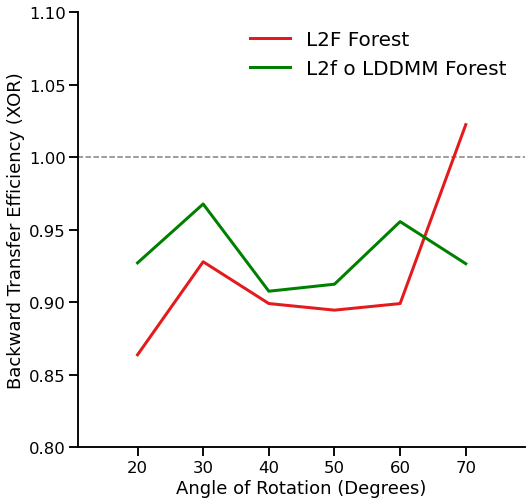

In [151]:
sns.set_context("talk")
colors = sns.color_palette("Set1", n_colors = 2)
algorithms = ['L2F Forest', 'L2f o LDDMM Forest']
angle_sweep = range(20,75,10)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(angle_sweep, mean_te[0],linewidth = 3, label=algorithms[0], c=colors[0])
ax.plot(angle_sweep, mean_te[1],linewidth = 3, label=algorithms[1], c='g')
# ax.set_xticks(range(0,91,10))
ax.set_ylim((0.8,1.1))
ax.set_xlim((11,79))
ax.set_xlabel('Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)
ax.legend(loc='upper right', fontsize=20, frameon=False)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

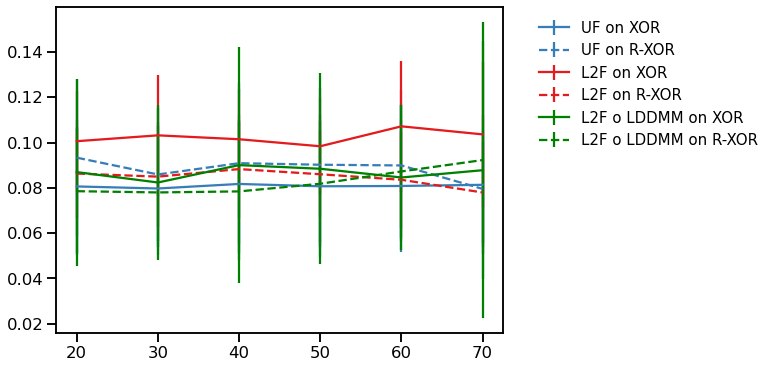

In [179]:
labels = ["UF on XOR", "UF on R-XOR", "L2F on XOR", "L2F on R-XOR", "L2F o LDDMM on XOR", "L2F o LDDMM on R-XOR"]
ls = ['-', '--']
colors = [sns.color_palette("Set1", n_colors = 2)[1], sns.color_palette("Set1", n_colors = 2)[0], 'g']
c_ind = [0,0,1,1,2,2]
ls_ind = [0,1,0,1,0,1]
fig, ax = plt.subplots(1,1, figsize=(8,6))
for i in range(6):
    ax.errorbar(angle_sweep, mean_error[i,:], std_error[i,:], label=labels[i], ls=ls[ls_ind[i]], c=colors[c_ind[i]])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15, frameon=False)

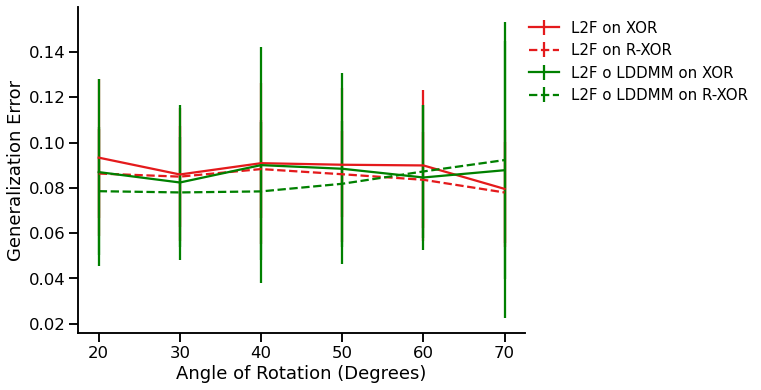

In [184]:
labels = ["L2F on XOR", "L2F on R-XOR", "L2F o LDDMM on XOR", "L2F o LDDMM on R-XOR"]
ls = ['-', '--']
colors = [sns.color_palette("Set1", n_colors = 2)[0], 'g']
inds = [1,3,4,5]
c_ind = [0,0,1,1]
ls_ind = [0,1,0,1]
fig, ax = plt.subplots(1,1, figsize=(8,6))
for i in range(len(inds)):
    ax.errorbar(angle_sweep, mean_error[inds[i],:], std_error[inds[i],:], label=labels[i], ls=ls[ls_ind[i]], c=colors[c_ind[i]])
    ax.legend(bbox_to_anchor=(0.98, 1), loc='upper left', fontsize=15, frameon=False)
ax.set_xlabel('Angle of Rotation (Degrees)')
ax.set_ylabel('Generalization Error')
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

In [18]:
# start_time = time.time()
mc_rep = 200
n_test = 1000
n_trees = 10
n_step = 0.5
n_xor = (100*np.arange(0.5, 7.25, step=n_step)).astype(int)
n_rxor = (100*np.arange(0.5, 7.50, step=n_step)).astype(int)

mean_error = np.zeros((6, len(n_xor)+len(n_rxor)))
std_error = np.zeros((6, len(n_xor)+len(n_rxor)))

mean_te = np.zeros((4, len(n_xor)+len(n_rxor)))
std_te = np.zeros((4, len(n_xor)+len(n_rxor)))

for i,n1 in enumerate(n_xor):
    print('starting to compute %s xor\n'%n1)
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            n1,0,task2_angle=np.pi/4,
            max_depth=ceil(log2(750))
        ) for _ in range(mc_rep)
      )
    )
    mean_error[:,i] = np.mean(error,axis=0)
    std_error[:,i] = np.std(error,ddof=1,axis=0)
    mean_te[0,i] = np.mean(error[:,0])/np.mean(error[:,1])
    mean_te[1,i] = np.mean(error[:,2])/np.mean(error[:,3])
    mean_te[2,i] = np.mean(error[:,0])/np.mean(error[:,4])
    mean_te[3,i] = np.mean(error[:,2])/np.mean(error[:,5])

    if n1==n_xor[-1]:
        for j,n2 in enumerate(n_rxor):
            print('starting to compute %s rxor\n'%n2)
            
            error = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                delayed(experiment)(
                    n1,n2,task2_angle=np.pi/4,
                    max_depth=ceil(log2(750))
                ) for _ in range(mc_rep)
              )
            )
            mean_error[:,i+j+1] = np.mean(error,axis=0)
            std_error[:,i+j+1] = np.std(error,ddof=1,axis=0)
            mean_te[0,i+j+1] = np.mean(error[:,0])/np.mean(error[:,1])
            mean_te[1,i+j+1] = np.mean(error[:,2])/np.mean(error[:,3])
            mean_te[2,i+j+1] = np.mean(error[:,0])/np.mean(error[:,4])
            mean_te[3,i+j+1] = np.mean(error[:,2])/np.mean(error[:,5])

# print("--- %s seconds ---" % (time.time() - start_time))

starting to compute 50 xor

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
starting to compute 100 xor

[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
starting to compute 150 xor

[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
starting to compute 200 xor

[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend 

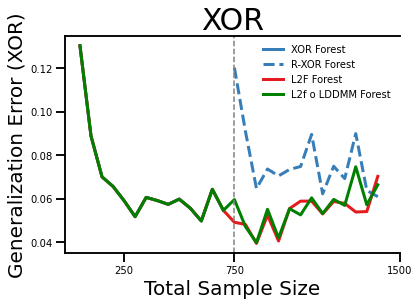

In [24]:
algorithms = ['XOR Forest', 'R-XOR Forest', 'L2F Forest', 'L2f o LDDMM Forest']
fig,ax1 = plt.subplots(1)
ax1.plot(n1s, mean_error[0,:len(n1s)], label=algorithms[0], c=colors[1], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.plot(ns[len(n1s):], mean_error[2, len(n1s):], label=algorithms[1], c=colors[1], ls=ls[1], lw=3)
ax1.plot(ns, mean_error[1], label=algorithms[2], c=colors[0], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
ax1.plot(ns, mean_error[4], label=algorithms[3], c='g', ls=ls[np.sum(1 > 1).astype(int)], lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK1), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=10, frameon=False)
#ax1.set_ylim(0.09, 0.21)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#ax1.set_yticks([0.1,0.15, 0.2])
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
ax1.set_title('XOR', fontsize=30)

right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]

# ax1.hlines(1, 50,1500, colors='gray', linestyles='dashed',linewidth=1.5)

# ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
# ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

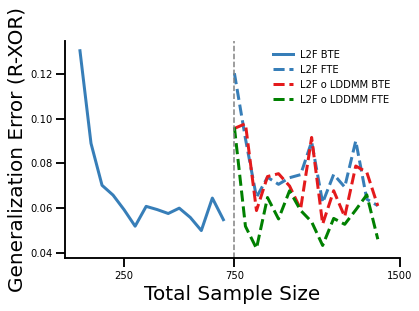

In [23]:
fig,ax1 = plt.subplots(1)
algorithms = ['XOR Forest', 'R-XOR Forest', 'L2F Forest', 'L2f o LDDMM Forest']
ax1.plot(n1s, mean_error[0,:len(n1s)], label=algorithms[0], c=colors[1], ls=ls[np.sum(0 > 1).astype(int)], lw=3)
ax1.plot(ns[len(n1s):], mean_error[2, len(n1s):], label=algorithms[1], c=colors[1], ls=ls[1], lw=3)

ax1.plot(ns[len(n1s):], mean_error[3, len(n1s):], label=algorithms[2], c=colors[0], ls=ls[1], lw=3)
ax1.plot(ns[len(n1s):], mean_error[5, len(n1s):], label=algorithms[3], c='g', ls=ls[1], lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK2), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=10, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")

right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)


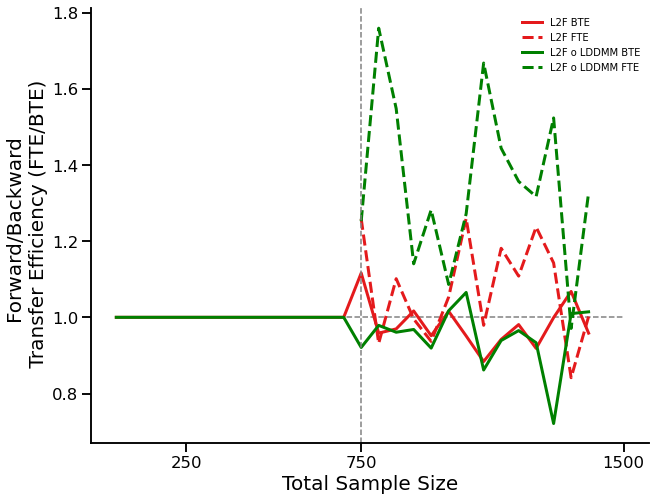

In [22]:
algorithms = ['L2F BTE', 'L2F FTE', 'L2F o LDDMM BTE', 'L2F o LDDMM FTE']
colors = sns.color_palette("Set1", n_colors = 2)
ls=['-', '--']
n1s = n_xor
n2s = n_rxor
ns = np.concatenate((n1s, n2s + n1s[-1]))
TASK1='XOR'
TASK2='R-XOR'
fontsize=20
labelsize=10

fig,ax1 = plt.subplots(1, figsize=(10,8))

ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.plot(ns, mean_te[2], label=algorithms[2], c='g', ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[3, len(n1s):], label=algorithms[3], c='g', ls=ls[1], lw=3)
ax1.set_ylabel('Forward/Backward \n Transfer Efficiency (FTE/BTE)', fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=labelsize, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.set_xticks([250,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.hlines(1, 50,1500, colors='gray', linestyles='dashed',linewidth=1.5)

# ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
# ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

### rotation angle = pi/4; varying sample sizes

In [147]:
# estimate affines for either task

start_time = time.time()
mc_rep = 100

errors_all = {}
affines_model1 = {}
affines_model2 = {}
n_train = [500]

for i in range(len(n_train)):
    print("n_train =", n_train[i])
    results = np.array(
        Parallel(n_jobs=-1,verbose=2)(
        delayed(exp)(n_task1=n_train[i], n_task2=n_train[i], n_trees=20) for _ in range(mc_rep)
        )
    )
    errors_all[i] = results[:, 0]
    affines_model1[i] = results[:, 1]
    affines_model2[i] = results[:, 2]
print("--- %s seconds ---" % (time.time() - start_time))

n_train = 500
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.9min
--- 1086.139965057373 seconds ---
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.1min finished


In [158]:
# find trials where task1/task2 was (almost) successfully predicted
inds1 = np.array([errors_all[0][i][-2] for i in range(100)]) < 0.5
inds2 = np.array([errors_all[0][i][-1] for i in range(100)]) < 0.5

In [165]:
# estimated affines for task1/task2
affine1 = np.mean(np.array([affines_model1[0][i] for i in range(100)])[inds1], axis=0)
affine2 = np.mean(np.array([affines_model2[0][i] for i in range(100)])[inds2], axis=0)

In [166]:
affine1

array([[ 0.81473565,  0.57445664,  0.        ],
       [-0.57445664,  0.81473565,  0.        ],
       [-0.58150549, -0.13890741,  1.        ]])

In [167]:
affine2

array([[ 0.79482773, -0.60329648,  0.        ],
       [ 0.60329648,  0.79482773,  0.        ],
       [ 0.34364547, -1.10930593,  1.        ]])

In [420]:
initial_affines = {}
initial_affines[1] = affine1
initial_affines[2] = affine2

In [422]:
pickle_out = open("estimated_initial_affines-45deg-n_sample=500-n_trial=100-n_trees=20.pickle", "wb")
pickle.dump(initial_affines, pickle_out)
pickle_out.close()

array([[ 0.81473565,  0.57445664,  0.        ],
       [-0.57445664,  0.81473565,  0.        ],
       [-0.58150549, -0.13890741,  1.        ]])

In [217]:
# compute generalization errors

start_time = time.time()
mc_rep = 50

errors_all_affine = {}
n_train = [100, 200, 300, 400, 500, 600, 700, 800]

for i in range(len(n_train)):
    print("n_train =", n_train[i])
    errors = np.array(
        Parallel(n_jobs=-1,verbose=2)(
        delayed(exp)(n_task1=n_train[i], n_task2=n_train[i], n_trees=20) for _ in range(mc_rep)
        )
    )
    errors_all_affine[i] = errors

print("--- %s seconds ---" % (time.time() - start_time))

n_train = 100
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
n_train = 200
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
n_train = 300
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
n_train = 400
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
n_train = 500
[Parallel(n_jobs=-

In [224]:
import pickle 

pickle_out = open("errors-pi_4-n_sample=100_800_100-n_rep=50-initial_affine.pickle", "wb")
pickle.dump(errors_all_affine, pickle_out)
pickle_out.close()

### plot results

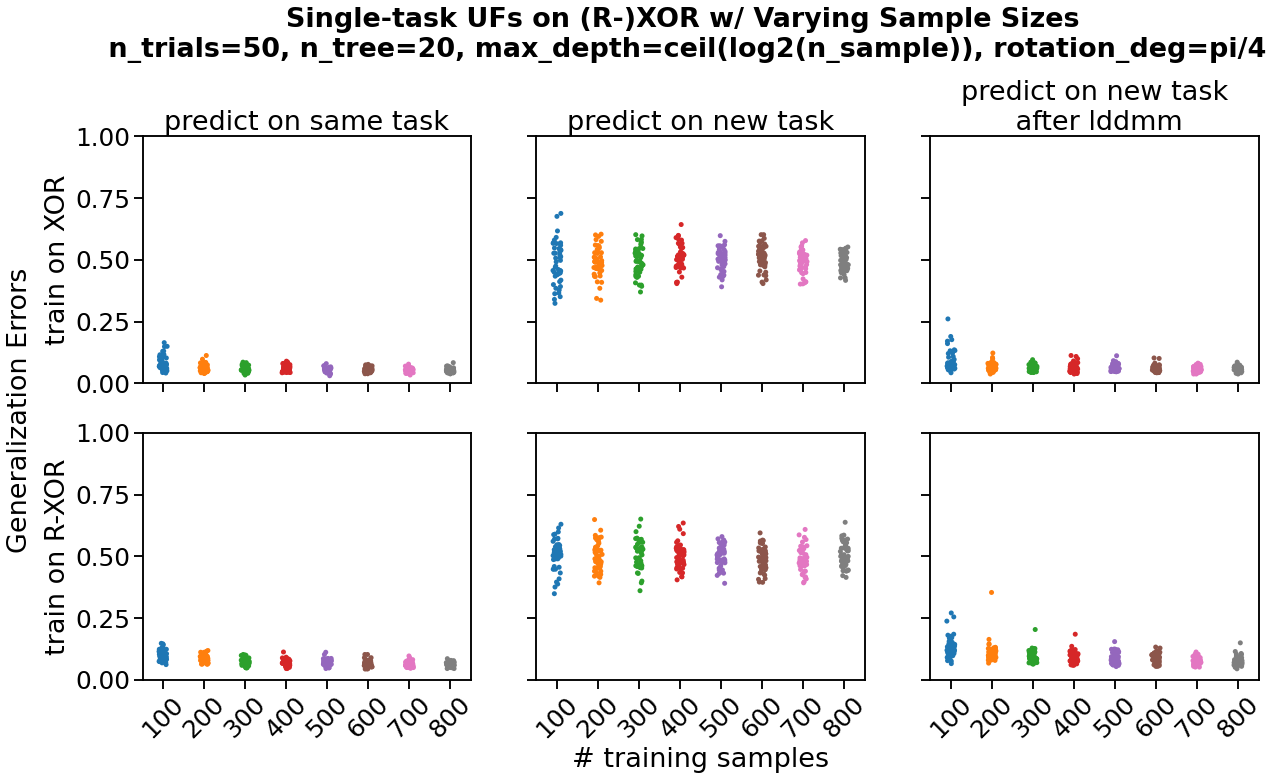

In [239]:
n_samples = np.arange(100,900,100)
fig, axs = plt.subplots(2,3, figsize=(20,10), sharex=True, sharey=True)
seqs = [0,1,4,3,2,5]
idx = -1
for i in range(2):
    for j in range(3):
        idx += 1
        e = np.array([errors_all_affine[n][:,seqs[idx]] for n in range(8)]).T
        df = pd.DataFrame(e)
        df = df.melt(value_vars=df.columns)
        ax = axs[i,j]
        sns.stripplot(data=df, x='variable', y='value', ax=ax)
        plt.ylim((0,1))
        ax.set_xlabel('')
        if i == 0:
            ax.set_ylabel('train on XOR')
            if j == 0:
                ax.set_title('predict on same task')
            elif j == 1:
                ax.set_title('predict on new task')
            else:
                ax.set_title('predict on new task\n after lddmm')
        else:
            ax.set_ylabel('train on R-XOR')
            ax.set_xticklabels((ax.get_xticks()+1) * 100, rotation=45)
            if j == 1:
                ax.set_xlabel('# training samples')
        if j != 0:
            ax.set_ylabel('')
fig.text(0.5, 0.99, 'Single-task UFs on (R-)XOR w/ Varying Sample Sizes\n n_trials=50, n_tree=20, max_depth=ceil(log2(n_sample)), rotation_deg=pi/4', ha='center', fontweight='bold')
fig.text(0.04, 0.5, 'Generalization Errors', rotation=90, ha='center', va='center')
# plt.tight_layout()
# plt.savefig('1-1', bbox_inches='tight')

### varying rotation angle; training sample = 500

In [313]:
start_time = time.time()
mc_rep = 50

# errors_all_affine_angles = {}
n_train = 500
# task2_angles = np.array([20, 30, 40, 50, 60, 70]) * np.pi/180
task2_angles = np.array([70]) * np.pi/180

for i in range(len(task2_angles)):
    print("task2_angle =", task2_angles[i])
    errors = np.array(
        Parallel(n_jobs=-1,verbose=2)(
        delayed(exp)(n_task1=n_train, n_task2=n_train, n_trees=20, task2_angle=task2_angles[i]) for _ in range(mc_rep)
        )
    )
    # errors_all_affine_angles[i] = errors

print("--- %s seconds ---" % (time.time() - start_time))

task2_angle = 1.2217304763960306
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.4min
--- 525.6686661243439 seconds ---
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.8min finished


In [317]:
errors_all_affine_angles[5] = errors

In [318]:
import pickle 

pickle_out = open("errors-angles=20_70_10-n_sample=500-n_rep=50-initial_affine.pickle", "wb")
pickle.dump(errors_all_affine_angles, pickle_out)
pickle_out.close()

In [23]:
pickle_in = open("errors-angles=20_70_10-n_sample=500-n_rep=50.pickle", "rb")
e4 = pickle.load(pickle_in)

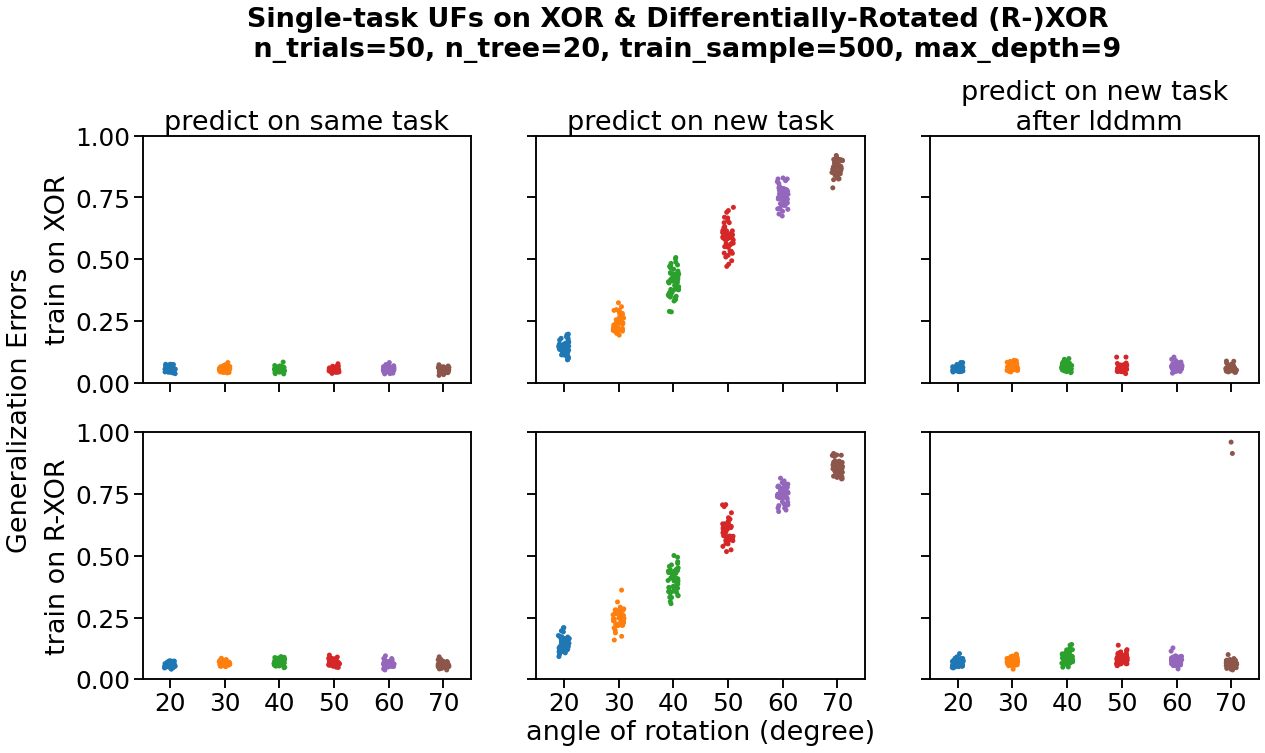

In [322]:
fig, axs = plt.subplots(2,3, figsize=(20,10), sharex=True, sharey=True)
idx = -1
seqs = [0,1,4,3,2,5]
for i in range(2):
    for j in range(3):
        idx += 1
        e = np.array([errors_all_affine_angles[n][:,seqs[idx]] for n in range(6)]).T
        df = pd.DataFrame(e)
        df = df.melt(value_vars=df.columns)
        ax = axs[i,j]
        sns.stripplot(data=df, x='variable', y='value', ax=ax)
        plt.ylim((0,1))
        ax.set_xlabel('')
        if i == 0:
            ax.set_ylabel('train on XOR')
            if j == 0:
                ax.set_title('predict on same task')
            elif j == 1:
                ax.set_title('predict on new task')
            else:
                ax.set_title('predict on new task\n after lddmm')
        else:
            ax.set_ylabel('train on R-XOR')
            ax.set_xticklabels((ax.get_xticks()+2) * 10)
            if j == 1:
                ax.set_xlabel('angle of rotation (degree)')
        if j != 0:
            ax.set_ylabel('')
fig.text(0.5, 0.99, 'Single-task UFs on XOR & Differentially-Rotated (R-)XOR \n n_trials=50, n_tree=20, train_sample=500, max_depth=9', ha='center', fontweight='bold')
fig.text(0.04, 0.5, 'Generalization Errors', rotation=90, ha='center', va='center')
# plt.tight_layout()
plt.savefig('1-2', bbox_inches='tight')